# TODO

- Latest Baseline
- ワークフロー確保

# Setting

In [1]:
import sys

import numpy as np
import polars as pl
from typing import Final
import seaborn as sns
import matplotlib.pyplot as plt

root_dir = "../../"
if root_dir not in sys.path:
    sys.path.append(root_dir)
from modules import config as cfg
from modules import utils, preprosess, training, predict, metrics, workflow

exp = "exp23"
utils.set_seed(cfg.Params.seed)

# Read data

In [2]:
train, test, submit = utils.get_data(debug_mode=False)

# Preprocessing

In [3]:
train = preprosess.drop_null_columns(train)
test  = preprosess.drop_null_columns(test)

## Split fold

In [4]:
train = preprosess.assign_stratified_k_fold(train)

## Convert

In [5]:
# testのBankStateの"PR"はtrainにないため，一番多いCAに変換
test = test.with_columns(pl.col("BankState").str.replace("PR", "CA"))

# 地名を座標に変換
train = preprosess.convert_to_latlng(train)
test  = preprosess.convert_to_latlng(test)

# DisbursementDateとApprovalDateを数値に変換
cols  = ["DisbursementDate", "ApprovalDate"]
train = preprosess.convert_date_to_year(train, cols)
test  = preprosess.convert_date_to_year(test, cols)
train = preprosess.convert_date_to_month(train, cols)
test  = preprosess.convert_date_to_month(test, cols)
train = preprosess.convert_date_to_day(train, cols)
test  = preprosess.convert_date_to_day(test, cols)

# 金額データの数値化
cols  = ["DisbursementGross",  "GrAppv", "SBA_Appv"]
train = preprosess.convert_money_data(train, cols)
test  = preprosess.convert_money_data(test, cols)

# 一致しているか
eqs = [
    ["State", "BankState"],
]
train = preprosess.add_eq(train, eqs)
test  = preprosess.add_eq(test, eqs)

# DisbursementDateとApprovalDateの差を計算
train = preprosess.add_diff_disbursement_with_approval(train)
test  = preprosess.add_diff_disbursement_with_approval(test)

# Sectorを職業別にする
train = preprosess.unify_same_sector(train)
test  = preprosess.unify_same_sector(test)

# ラベルデータをSBA_Appvの統計量で置き換える
AGG_NAME: Final[list] = ["mean", "median", "max", "min"]
AGG_COL: Final[str] = "SBA_Appv"
VS_AGG_COLS: Final[list] = [
    'NewExist', 
    'RevLineCr', 
    'LowDoc', 
    'UrbanRural', 
    'CreateJob'
]
train, test = preprosess.convert_aggregation_data(train, test, AGG_COL, VS_AGG_COLS)

# 差の計算
diffs = [
    ["DisbursementGross", "GrAppv"],   # 支払われた額 vs 銀行承認額
    ["DisbursementGross", "SBA_Appv"], # 支払われた額 vs SBA承認額
    ["GrAppv", "SBA_Appv"],            # 銀行承認額 vs SBA承認額
]

# ラベルデータをSBA_Appvの統計量で置き換えたもの vs SBA_Appv
for col_name in VS_AGG_COLS:
    for name in AGG_NAME:
        diff = [AGG_COL, f"{col_name}_{AGG_COL}_{name}"]
        diffs.append(diff)

train = preprosess.add_diff(train, diffs)
test  = preprosess.add_diff(test, diffs)

# 割合の計算
divs = [
    ["DisbursementGross", "Term"], 
    ["GrAppv", "Term"], 
    ["SBA_Appv", "Term"], 
    ["NoEmp", "Term"], 
    ["DisbursementGross", "NoEmp"], 
    ["GrAppv", "NoEmp"], 
    ["SBA_Appv", "NoEmp"], 
    ["DisbursementGross_GrAppv_diff", "Term"], 
    ["DisbursementGross_SBA_Appv_diff", "Term"], 
    ["GrAppv_SBA_Appv_diff", "Term"], 
    ["DisbursementGross_GrAppv_diff", "NoEmp"], 
    ["DisbursementGross_SBA_Appv_diff", "NoEmp"], 
    ["GrAppv_SBA_Appv_diff", "NoEmp"]
]
train = preprosess.add_div(train, divs)
test  = preprosess.add_div(test, divs)

## Target encoding

In [6]:
cols = [
    # "Sector",
    "UrbanRural", 
    "RevLineCr", 
    "LowDoc", 
    "ApprovalFY", 
    "FranchiseCode",
    "RetainedJob",
    "CreateJob",
    "NoEmp",
    "Term",
    "State",
    "BankState",
    "Sector",
    "NewExist",
]
train, test = preprosess.target_encoding(train, test, cols)

## Label encoding
CVによるtarget encodingでは同じカテゴリカル変数に異なる値が割り当てられるのでlabel encodingを併用する

In [7]:
cols = ['RevLineCr', 'LowDoc', 'State', 'BankState']
train, test = preprosess.label_encoding(train, test, cols)

# Drop columns

In [8]:
# 不要なカラムの削除
del_cols = [
    # 地名系
    "City",
    # "State",
    # "BankState",
    # d-b-y系
    "DisbursementDate",
    "ApprovalDate",
    # "ApprovalFY",
    # ラベルエンコーディング済み
    # "RevLineCr",
    # "LowDoc",
]

for col_name in VS_AGG_COLS:
    for name in AGG_NAME:
        del_cols.append(f"{col_name}_{AGG_COL}_{name}")

train = train.drop(del_cols)
test  = test.drop(del_cols)

# Training

In [9]:
lgb_params = {
    "objective": "binary",
    "metric": "None",
    "learning_rate": cfg.Params.lgb_learning_rate,
    "max_depth": cfg.Params.lgb_max_depth,
    "n_estimators": cfg.Params.lgb_n_estimators,
    "colsample_bytree": cfg.Params.lgb_colsample_bytree,
    "importance_type": "gain",
    "verbose": -1,
    "seed": cfg.Params.seed,
}

In [10]:
# weightのチューニング
zero_weights = np.arange(0.74, 0.88, 0.01)
_, best_zero_weight = workflow.tuning_loss_weight(train, lgb_params, zero_weights)
print(f"best zero weight: {best_zero_weight}")

--------------------------------------------------------------------------------
START fold 1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[953]	valid_0's macroF1: 0.692153
Time:  30.178[s]
--------------------------------------------------------------------------------
START fold 2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's macroF1: 0.683561
Time:  26.449[s]
--------------------------------------------------------------------------------
START fold 3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[838]	valid_0's macroF1: 0.668159
Time:  24.769[s]
--------------------------------------------------------------------------------
START fold 4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[322]	valid_0's macroF1: 0.673615
Time:  15.

In [11]:
oof, models = training.fit_lgbm(train, lgb_params=lgb_params, zero_weight=best_zero_weight)

--------------------------------------------------------------------------------
START fold 1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[403]	valid_0's macroF1: 0.693014
Time:  8.057[s]
--------------------------------------------------------------------------------
START fold 2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[359]	valid_0's macroF1: 0.686758
Time:  7.705[s]
--------------------------------------------------------------------------------
START fold 3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[370]	valid_0's macroF1: 0.663841
Time:  7.926[s]
--------------------------------------------------------------------------------
START fold 4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[268]	valid_0's macroF1: 0.680664
Time:  6.379[s]
------------------------------------

# Prediction

In [12]:
threshold = 0.5

## CV score

In [13]:
oof_truth = train[cfg.Cols.target].to_numpy()
oof_hat = predict.predict_class(oof, threshold=threshold)
cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
print(cv_score)

0.683372469916163


## Test prediction

In [14]:
pred_prob = predict.predict_probability(models, test)
pred_class = predict.predict_class(pred_prob, threshold=threshold)

## Check result

### oofとtestの予測値分布を比較してバグを確認

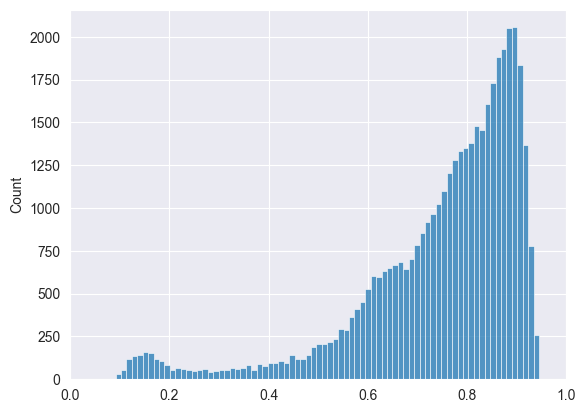

In [15]:
sns.histplot(pred_prob)
plt.xlim(0.0, 1.0)
plt.show()

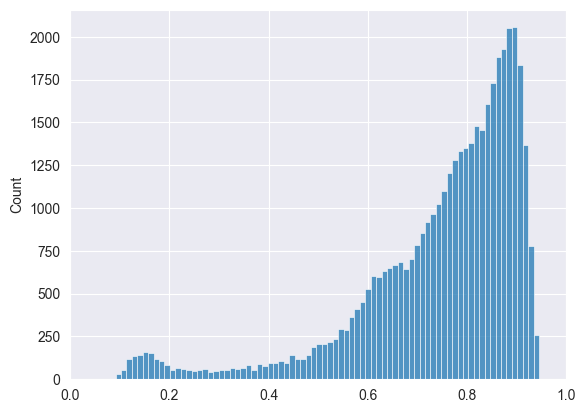

In [16]:
sns.histplot(pred_prob)
plt.xlim(0.0, 1.0)
plt.show()

### 予測値の1の割合を確認

In [17]:
print(pred_class.sum() / len(pred_class))

0.9200387633544483


### oofにおける混同行列を確認

True Negative Rate (0の正解率): 0.37
True Positive Rate (1の正解率): 0.96


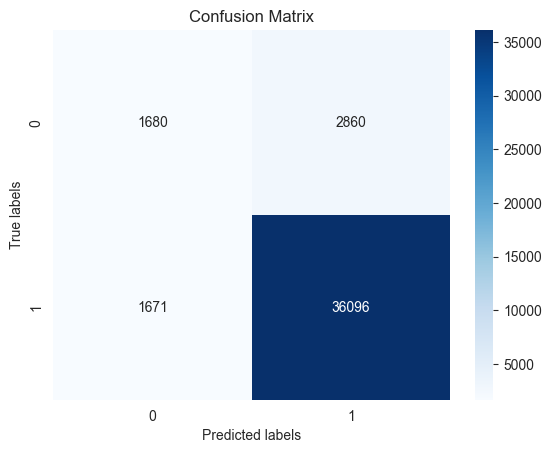

In [18]:
metrics.show_confusion_matrix(oof_truth, oof_hat)

## Submit

In [20]:
submit = submit.with_columns([pl.Series(cfg.Cols.sub_pred, pred_class)])
utils.make_submission(submit, exp, cv_score)